In [1]:
# Author: Samantha Tetef
# Created: 4.19.21
# Title: GP_BUCB_Example

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import itertools

from sklearn.gaussian_process import GaussianProcessRegressor

## Testing UCB1, GP-UCG, and  GP-BUCB algorithms

### Creating synthetic data

In [3]:
N = 1000
X = np.linspace(0,1,N)

# parameter space
coeffs = np.linspace(-3,3,21)
print(f"Possible coeffs: {coeffs}")

# all possible actions
Action_Set = np.array(list(itertools.product(coeffs, repeat=3)))
num_permutes = Action_Set.shape[0]
print(f"Actions set shappe: {Action_Set.shape}")

Possible coeffs: [-3.  -2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9
  1.2  1.5  1.8  2.1  2.4  2.7  3. ]
Actions set shappe: (9261, 3)


In [4]:
def add_noise_to_output(Y, sig=0.1):
    """Add random gaussian noise to output."""
    noise = np.random.normal(loc=0.0, scale=sig, size=Y.shape)
    return Y + noise 

def add_systematic_low_to_actions(actions_tuple, err_percent=0.05):
    """Takes aech action and makes the result actually lower."""
    a, b, c = actions_tuple
    return [action*(1 - err_percent) for action in actions_tuple]

def add_systematic_high_to_actions(actions_tuple, err_percent=0.05):
    """Takes aech action and makes the result actually higher."""
    return [action*(1 + err_percent) for action in actions_tuple]

def add_randomness_to_actions(actions_tuple, sig=0.1):
    """Takes aech action and makes the result actually random."""
    noise = np.random.normal(loc=0.0, scale=sig, size=len(actions_tuple))
    return actions_tuple + noise

def get_output(actions, X):
    """Transforms actions and input into output."""
    return actions[0]*X**2 + actions[1]*X + actions[2]

In [5]:
num_repeats = 10
Y = np.zeros((num_permutes*num_repeats,N))
# targets are polynomial using actions as coeffs
for i in range(num_permutes):
    actions = Action_Set[i]
    # no error
    Y[i] = get_output(actions, X)
    # noise only
    Y[i + num_permutes] = add_noise_to_output(Y[i])
    # systematic low to coeffs
    low_actions = add_systematic_low_to_actions(actions)
    Y[i + num_permutes*2] = add_noise_to_output(get_output(low_actions, X))
    # systematic high to coeffs
    high_actions = add_systematic_high_to_actions(actions, err_percent=0.01)
    Y[i + num_permutes*3] = add_noise_to_output(get_output(high_actions, X))
    # now lots of randomness
    for j in range(4, num_repeats):
        # random sampling of coeffs
        rand_actions = add_randomness_to_actions(actions)
        Y[i + num_permutes*j] = add_noise_to_output(get_output(rand_actions, X))

print(Y.shape)

(92610, 1000)


In [6]:
Dataset = np.tile(Action_Set, (num_repeats,1))
Dataset.shape

(92610, 3)

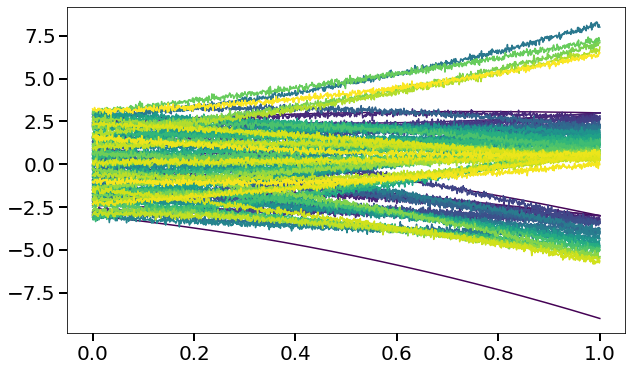

In [7]:
# displaying data
fig, ax = plt.subplots(figsize=(10,6))
fontsize = 16

Colors = plt.cm.viridis(np.arange(num_permutes*num_repeats)/(num_permutes*num_repeats-1))

for i in range(len(Y)):
    if not i % 1000:
        plt.plot(X, Y[i], '-', c=Colors[i])

plt.xticks(fontsize=fontsize+4)
plt.yticks(fontsize=fontsize+4)

ax.tick_params(direction='out', width=2, length=8)
ax.tick_params(direction='out', which='minor', width=1, length=5)

plt.show()

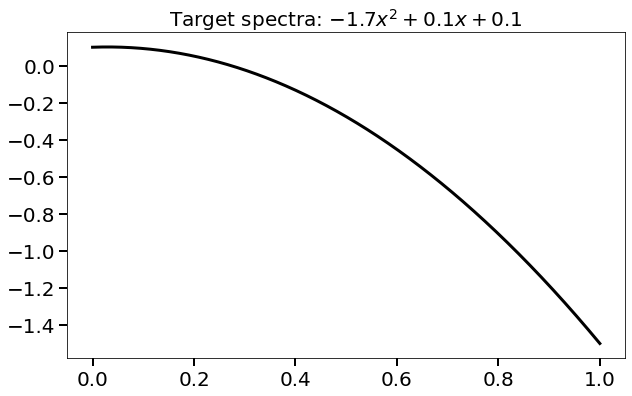

In [8]:
# create wanted "target"
target_action = (-1.7, 0.1, 0.1)
target = target_action[0]*X**2 + target_action[1]*X + target_action[2]

fig, ax = plt.subplots(figsize=(10,6))
fontsize = 16

plt.plot(X, target, 'k-', linewidth=3)

plt.title(f"Target spectra: ${target_action[0]}x^2 + {target_action[1]}x + {target_action[2]}$", fontsize=20)
plt.xticks(fontsize=fontsize+4)
plt.yticks(fontsize=fontsize+4)

ax.tick_params(direction='out', width=2, length=8)
ax.tick_params(direction='out', which='minor', width=1, length=5)

plt.show()

In [9]:
def MSE(Y, target):
    return np.sum((Y-target)**2, axis=1)/Y.shape[0]

In [10]:
mse = np.round(MSE(Y, target), 1)

In [11]:
# create dataframe
columns = ['a', 'b', 'c']
df = pd.DataFrame(data=Dataset, columns=columns)
df['MSE'] = mse
df

,a,b,c,MSE
0,-3.0,-3.0,-3.0,0.3
1,-3.0,-3.0,-2.7,0.3
2,-3.0,-3.0,-2.4,0.2
3,-3.0,-3.0,-2.1,0.2
4,-3.0,-3.0,-1.8,0.2
...,...,...,...,...
92605,3.0,3.0,1.8,0.3
92606,3.0,3.0,2.1,0.3
92607,3.0,3.0,2.4,0.3
92608,3.0,3.0,2.7,0.4


In [12]:
def ucb1_policy(df, time_step, column_names, batch_size=3, ucb_scale=2.0):
    '''
    Applies GP-BUCB policy to generate recommendations.
    
    This is adapted from the tutorial found at
    https://jamesrledoux.com/algorithms/bandit-algorithms-epsilon-ucb-exp-python/
    
    Arguments:
        df - dataset on which to apply UCB policy
            type == dataframe
        t - current time step (start at 1)
            type == int
        ucb_scale - the scale of the upper bound
            default = 2.0
            type == float
    Returns:
        actions - a subset of the data with the highest ucb
            type == dataframe        
    '''
    grouped_df = df.groupby(column_names)
    grouped_df = grouped_df.agg(['mean', 'count', 'std'])
    
    grouped_df['ucb'] = grouped_df[('MSE', 'mean')] + \
        2 * grouped_df[('MSE', 'mean')] / np.sqrt(grouped_df[('MSE', 'mean')])
    
    # flip the MSE
    grouped_df['ucb'] = -grouped_df['ucb']
    
    scores = grouped_df.sort_values('ucb', ascending=False)

    recs = scores.index[:batch_size].values
    return recs

In [13]:
# Get recomendations for 5 time steps
Recomendations = []
total_time_steps = 5
for t in range(total_time_steps):
    recs = ucb1_policy(df, t + 1, columns)
    Recomendations.append(recs)

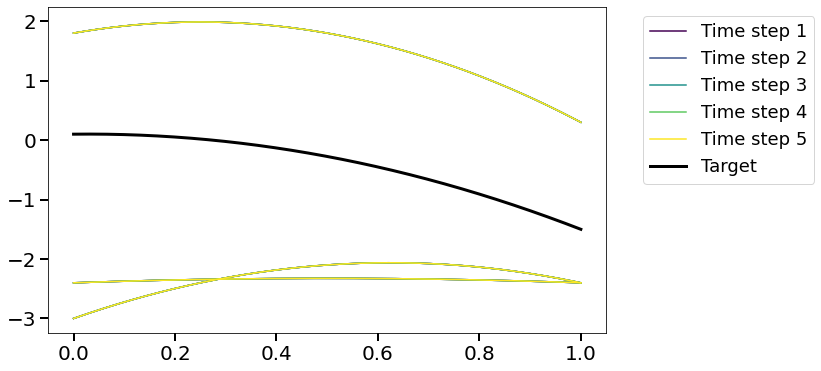

In [14]:
# displaying data
fig, ax = plt.subplots(figsize=(10,6))
fontsize = 16

Colors = plt.cm.viridis(np.arange(total_time_steps)/(total_time_steps-1))

for t in range(total_time_steps):
    i = 0
    for action in Recomendations[t]:
        if i == 0:
            plt.plot(X, get_output(action, X), '-', c=Colors[t], label=f"Time step {t+1}")
        else:
            plt.plot(X, get_output(action, X), '-', c=Colors[t])
        i += 1

plt.plot(X, target, 'k-', linewidth=3, label="Target")

plt.xticks(fontsize=fontsize+4)
plt.yticks(fontsize=fontsize+4)

ax.tick_params(direction='out', width=2, length=8)
ax.tick_params(direction='out', which='minor', width=1, length=5)

plt.legend(fontsize=18, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()